# 0. Introduction
## 0.1 Purpose of the project
*For a complete explanation of the project, please first refer to the README.txt and EXECUTIVE_SUMMARY.txt files available from the project folder.*

In this project, I work on **predicting future employee performance through competency measures collected during the standardised interviewing process**. The overall goal was to analyse which competencies work well as predictors, thus possibly **making the interviewing process more efficient** by deleting questions that tap into behaviours which are non-critical for the job at hand.

This is a win-win on part of both the employer and the employee: The employer can save time and money spent on interviewing the candidates, and increases the predictive validity of their personnel selection procedures. This leads to employees that are more suitable and potentially stay longer with the company, saving more opportunity costs. On the other hand, employees can showcase what they are best at and, as a substantial body of research in I-O-Psychology suggests, usually feel more engaged and satisfied in roles that match their skills better.

My intention behind uploading this and the following notebooks is to demonstrate a business case for People Analytics, and why the need for HR data scientists might rise in the future. I will show how **ML can render insights from even small samples and few predictors**, and how data professionals can help make HR more evidence-based on the long run.


## 0.2 Section objectives
This first notebook demonstrates the process of screening and cleaning the data, as much as the exploratory data analysis of the dataset. Usually, I would separate those two steps but for this very small and straightforward dataset, I summarised them in just one notebook.

# 1. Prepare the work environment

## 1.1 Set general options

In [1]:
#General options
options(scipen = 999,
        readr.num_columns = 0,
        warn = -1)

## 1.2 Set working directory

In [2]:
#Set wd
setwd("C:/Users/veren/github/ML_Project_Predict_Employee_Performance")

## 1.3 Load libraries
To start, I will load all the libraries needed for this project. The libraries have been formerly installed and therefore are only called and not installed again.

In [3]:
library(caret)
library(tidyverse)

Loading required package: lattice
Loading required package: ggplot2
-- Attaching packages --------------------------------------- tidyverse 1.3.0 --
v tibble  3.0.1     v dplyr   0.8.5
v tidyr   1.0.3     v stringr 1.4.0
v readr   1.3.1     v forcats 0.5.0
v purrr   0.3.4     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
x purrr::lift()   masks caret::lift()


## 1.4 Import user-defined functions

In [4]:
#Load functions
load("03_Objects/ud_functions.RData")

# 2. Load database

In [5]:
#Save database
perf <- read.csv("01_Data/performance.csv")

# 3. Data screening and cleaning
As mentioned above, usually, data screening and cleaning is one of the exercises that takes up most of a data scientist's time, and this has also been true for the majority of my past projects. However in this project, the clean-up is very short as I am working on a fabricated, simplified database as explained and the respective README.

In the future, I mean to upload a real-life project which is majorly concerned with the cleaning, screening and EDA part of the data.

In [6]:
summary(perf)

    quality      service_orientation   innovation     organisation  
 Min.   :2.000   Min.   :2.000       Min.   :1.000   Min.   :2.000  
 1st Qu.:3.000   1st Qu.:3.000       1st Qu.:3.000   1st Qu.:3.000  
 Median :3.000   Median :4.000       Median :3.000   Median :3.000  
 Mean   :3.502   Mean   :3.742       Mean   :3.249   Mean   :3.192  
 3rd Qu.:4.000   3rd Qu.:4.000       3rd Qu.:4.000   3rd Qu.:4.000  
 Max.   :5.000   Max.   :5.000       Max.   :5.000   Max.   :5.000  
                                                     NA's   :6      
 problem_solving   curiosity      determination       analysis     
 Min.   :2.00    Min.   :0.4553   Min.   :0.5398   Min.   :0.2095  
 1st Qu.:3.00    1st Qu.:0.7535   1st Qu.:0.8178   1st Qu.:0.5954  
 Median :4.00    Median :0.8698   Median :0.9280   Median :0.7475  
 Mean   :3.53    Mean   :0.8440   Mean   :0.8951   Mean   :0.7445  
 3rd Qu.:4.00    3rd Qu.:0.9706   3rd Qu.:1.0000   3rd Qu.:0.9233  
 Max.   :5.00    Max.   :1.0000   Max.  

In [7]:
#Put target variable first and convert into ordered factor
perf <- perf %>%
  dplyr::select(performance, quality:empowerment) %>% 
  mutate(performance = ordered(performance, levels = c("C", "B", "A")))

In [8]:
summary(perf$performance)

C   B   A 
 78 118  29

In [9]:
#Round all numerics to two decimals
perf <- perf %>% 
  mutate_if(is.numeric, ~round(., 2))

# 4. EDA
An exploratory data analysis is a good way to deepen the understanding of a dataset.
What I want to do is first understand every variable by itself, meaning to review their histograms, means, sd, ranges (numeric variables) or frequencies and levels (categorical variables) and describing missing or extreme values.

Thereafter, I will go on to bi- and multivariate analysis like correlations and multicollinearity, and how each predictor is related to the target variable.

**Note that** in this step, we will NOT perform any data transformation just yet. Any transformation which might be affected by statistics that are specific to this dataset (e.g. means, variances) will be done during pre-processing to avoid tempering with the test dataset which will be used during out-of-sample validation.

## 4.1 Summary

In [10]:
skimr::skim(perf)

-- Data Summary ------------------------
                           Values
Name                       perf  
Number of rows             225   
Number of columns          10    
_______________________          
Column type frequency:           
  factor                   1     
  numeric                  9     
________________________         
Group variables            None  

-- Variable type: factor -------------------------------------------------------
# A tibble: 1 x 6
  skim_variable n_missing complete_rate ordered n_unique top_counts          
* <chr>             <int>         <dbl> <lgl>      <int> <chr>               
1 performance           0             1 TRUE           3 B: 118, C: 78, A: 29

-- Variable type: numeric ------------------------------------------------------
# A tibble: 9 x 11
  skim_variable       n_missing complete_rate  mean    sd    p0   p25   p50
* <chr>                   <int>         <dbl> <dbl> <dbl> <dbl> <dbl> <dbl>
1 quality                     0 

As can be observed, 5 of the predictors (up until problem-solving) have ranges from 1 to 5, and 4 predictors (from curiosity) range from 0 to 1. This is because the first predictors are actual competency measures, while the last ones are measures of future potential. 

This finding gives us a hint that it is probably a good idea to normalise the data before feeding them into any ML model to avoid issues caused by different variances.

Also, the target variable seems to be imbalanced (only few employees got awarded an A). Imbalanced datasets may cause problems for some algorithms as overrepresented classes might be given more importance than the underrepresented ones. However, as we are mainly interested in which competencies convert a candidate into a potential A-performer, we definitely have to address imbalance in the later modelling phase.

In [11]:
glimpse(perf)

Rows: 225
Columns: 10
$ performance         <ord> A, B, B, C, C, C, B, C, C, B, C, B, B, C, B, B,...
$ quality             <dbl> 4, 3, 4, 3, 2, 3, 4, 4, 3, 4, 3, 3, 3, 3, 3, 3,...
$ service_orientation <dbl> 4, 3, 4, 3, 2, 3, 5, 4, 2, 5, 4, 4, 4, 3, 5, 5,...
$ innovation          <dbl> 2, 3, 4, 3, 4, 3, 4, 3, 2, 2, 2, 4, 2, 2, 3, 3,...
$ organisation        <dbl> 4, 3, 2, 3, 3, 3, 5, 2, 2, 3, 2, 4, 3, 2, 3, 3,...
$ problem_solving     <dbl> 4, 4, 4, 3, 3, 3, 4, 4, 3, 4, 3, 4, 3, 3, 3, NA...
$ curiosity           <dbl> 0.94, 0.60, 1.00, 0.96, 0.74, 1.00, 0.71, 0.94,...
$ determination       <dbl> 0.71, 0.90, 0.92, 1.00, 1.00, 0.79, 1.00, 0.77,...
$ analysis            <dbl> 0.88, 0.60, 1.00, 0.87, 0.93, 1.00, 0.55, 0.99,...
$ empowerment         <dbl> 0.69, 0.86, 0.92, 1.00, 0.75, 0.96, 0.94, 0.81,...


From both output cells above, we can tell that most of the predictors are highly skewed. In this case, it is best practice to either transform the data (e.g. log-transformation), or use robust methods during pre-processing (which will be further explained in the next notebook).

## 4.2 Histograms of variables and bivariate correlations

A first glimpse at the correlations and scatterplots shows that many of the predictors are highly intercorrelated, and also highly correlated with the target variable.

**Note: We cannot tell at this point whether this finding is caused by methodological artefact (e.g. competency and performance measures taken by the same person, biased attitudes towards the employees after the selection process, etc). However, it is very important to keep this curiosity in mind and critically address it with the company, as correlations above and beyond .40 are scarcely found in controlled predictive validity studies where psychometrics are used as predictors.**

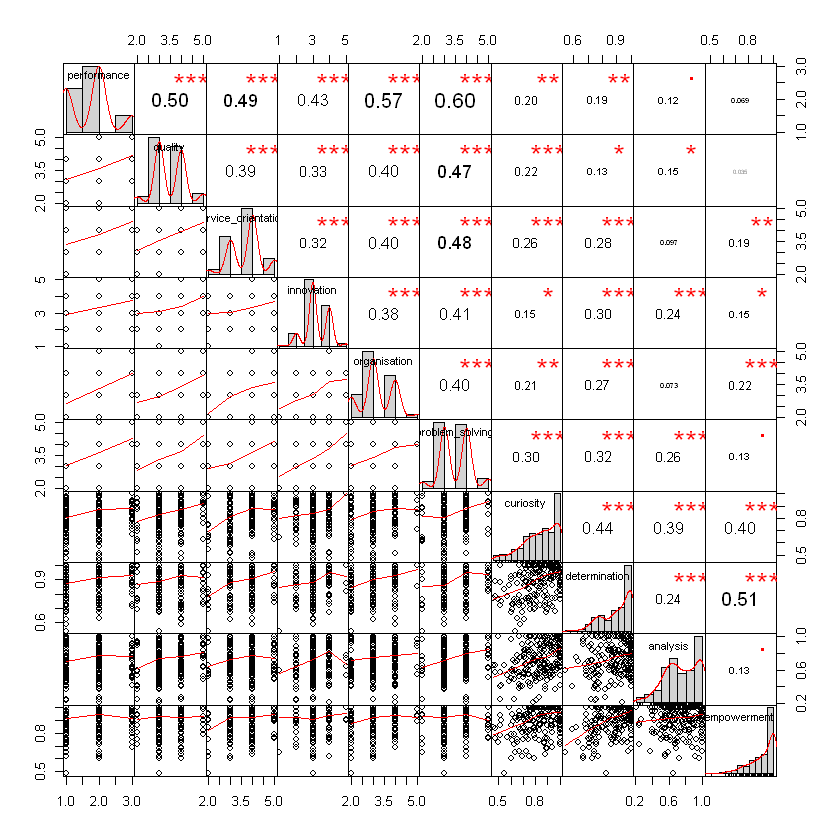

In [12]:
#Diagram with all variables
PerformanceAnalytics::chart.Correlation(mutate(perf, performance = as.integer(performance)))

## 4.3 Missing values

In [13]:
#There are missing values
anyNA(perf)

[1] TRUE

In [14]:
#Percentage of missing values in each variable
data.frame(percent_missing = round(colMeans(is.na(perf)*100),2))

,percent_missing
,<dbl>
performance,0.00
quality,0.00
service_orientation,0.00
innovation,0.00
organisation,2.67
problem_solving,4.44
curiosity,0.00
determination,0.00
analysis,0.00


There are only very few missing values in the dataset. With a percentage of less than 5% missing values on any given predictor variable, we can impute the missing values during the pre-processing phase, for example using the KNN method.

## 4.4 Extreme values

From the boxplots, we can observe that the competency measures (scale 1 to 5) are less skewed than the potential measures (scale 0 to 1). A possible explanation might be that potential is typically measured asking hypothetical questions ('What would you do if ....?'), as opposed to situational questions prompting the candidates to describe how they *actually* reacted ('Tell me about a situation when you had to ...'). Hypothetical questions leave more opportunities for the candidates to give socially desirable answers (although these might not necessarily reflect candidates' actual behaviours), thus potentially leading to mostly high ratings.

It is natural that the more skewed predictors show more outliers, too. As mentioned above, we will not delete outliers as they seem to be legitimte data points after all (within the possible range) and the problem has rather been caused by range restriction (see README.txt for an in-depth explanation). Instead, we will use robust methods as far as possible to address skewed predictors.

NULL


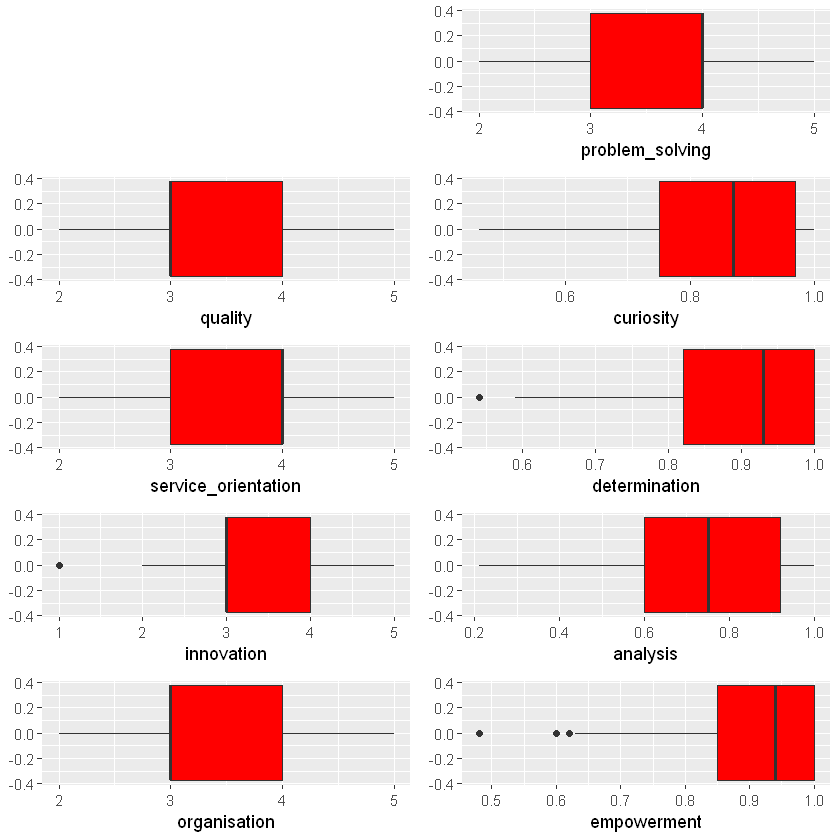

In [16]:
#Boxplots of competencies
perf_boxplots <- list()
for(i in 2:ncol(perf)){
  col <- names(perf)[i]
  ggp <- ggplot(perf, aes_string(x = col)) +
    geom_boxplot(fill = "red")
  perf_boxplots[[i]] <- ggp
}

multiplot(plotlist = perf_boxplots, cols = 2)

z-values are a good metric to review the magnitude of extreme values. In a two-tailed hypothesis, a z-value of +-2.57 is indicative of a value that falls into the most extreme percentile of the sample. A z-value of +-3.29 means that a total of only 0.2 percent of the population obtain a value that is even more extreme.

The z-values of our predictors confirm our former observations. Many of the predictors have negative skew. The long tail (fewer values making for a flat curve of the distribution) is to the lower end of the scales, meaning that most candidates who are later selected for their jobs obtain quite favourable ratings during the interview, and some lower values were possibly compensated for by high ratings on the other dimensions, or even measures not observable from the dataset that worked in favour of those persons.

In [17]:
#z-values
perf[-1] %>% 
  mutate_all(~scale(.)) %>% 
  summary()

      quality.V1      service_orientation.V1   innovation.V1   
 Min.   :-2.1412683   Min.   :-2.3898183     Min.   :-3.29948  
 1st Qu.:-0.7158678   1st Qu.:-1.0181114     1st Qu.:-0.36516  
 Median :-0.7158678   Median : 0.3535956     Median :-0.36516  
 Mean   : 0.0000000   Mean   : 0.0000000     Mean   : 0.00000  
 3rd Qu.: 0.7095327   3rd Qu.: 0.3535956     3rd Qu.: 1.10200  
 Max.   : 2.1349332   Max.   : 1.7253025     Max.   : 2.56916  
                                                               
   organisation.V1   problem_solving.V1      curiosity.V1    
 Min.   :-1.620259   Min.   :-2.199794   Min.   :-2.8165712  
 1st Qu.:-0.260731   1st Qu.:-0.762239   1st Qu.:-0.6894732  
 Median :-0.260731   Median : 0.675317   Median : 0.1907053  
 Mean   : 0.000000   Mean   : 0.000000   Mean   : 0.0000000  
 3rd Qu.: 1.098796   3rd Qu.: 0.675317   3rd Qu.: 0.9241874  
 Max.   : 2.458324   Max.   : 2.112872   Max.   : 1.1442320  
 NA's   :6           NA's   :10                       

## 4.5 Correlational Analysis

In [18]:
#Correlations between predictors
round(cor(mutate(perf, performance = as.integer(performance)),
          use = "complete.obs"), 2)

,performance,quality,service_orientation,innovation,organisation,problem_solving,curiosity,determination,analysis,empowerment
performance,1.00,0.50,0.48,0.46,0.59,0.59,0.20,0.18,0.10,0.07
quality,0.50,1.00,0.38,0.34,0.41,0.46,0.22,0.13,0.14,0.03
service_orientation,0.48,0.38,1.00,0.32,0.42,0.47,0.25,0.29,0.08,0.18
innovation,0.46,0.34,0.32,1.00,0.38,0.39,0.16,0.28,0.24,0.14
organisation,0.59,0.41,0.42,0.38,1.00,0.40,0.22,0.28,0.08,0.24
problem_solving,0.59,0.46,0.47,0.39,0.40,1.00,0.31,0.30,0.25,0.11
curiosity,0.20,0.22,0.25,0.16,0.22,0.31,1.00,0.47,0.41,0.42
determination,0.18,0.13,0.29,0.28,0.28,0.30,0.47,1.00,0.25,0.51
analysis,0.10,0.14,0.08,0.24,0.08,0.25,0.41,0.25,1.00,0.13
empowerment,0.07,0.03,0.18,0.14,0.24,0.11,0.42,0.51,0.13,1.00


The correlational analysis shows that the competency measures (namely 'quality awareness', 'service orientation', 'innovation', 'organisation' and 'problem-solving') are more highly related to the target variable then the potential measures ('curiosity', 'determination', 'analysis' and 'empowerment'). Possibly because the potential measures are not as important for customer service employees as the competency measures, or because of the issue raised above concerning the measurement method used (hypothetical questions). 

**Especially organisation and problem-solving are highly correlated to later on-the-job performance, giving us a hint about features that might work very well in any given ML algorithm.**

A minor concern are the correlations between different predictors, which is why we check for multicollinearity in the next step.

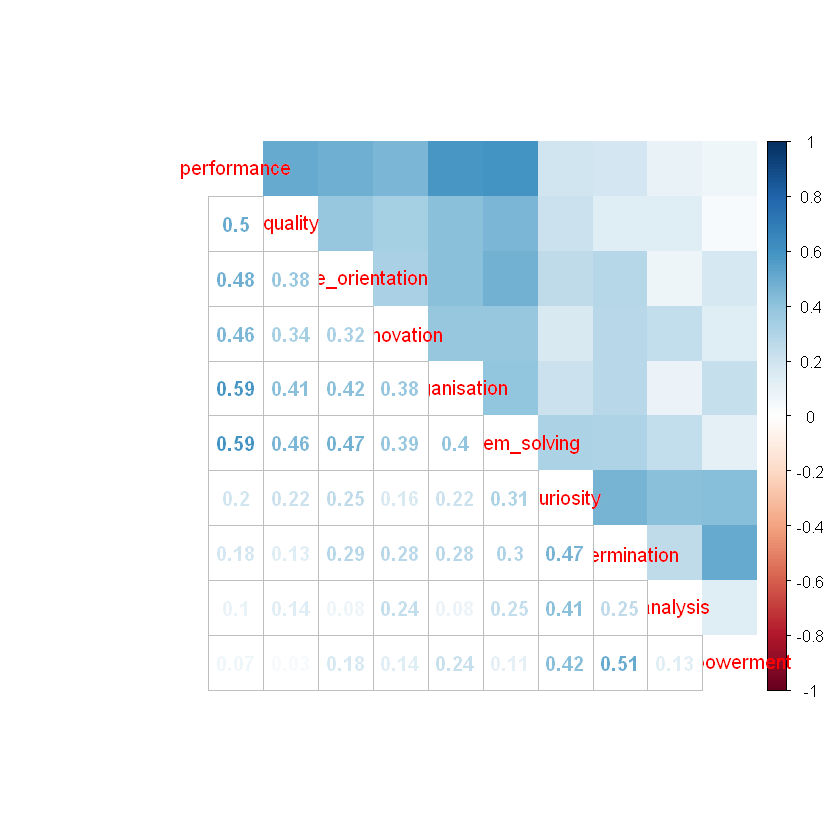

In [19]:
corrplot::corrplot.mixed(corr = cor(mutate(perf, performance = as.integer(performance)),
                                           use = "complete.obs"), upper = "shade")

The predictors' Variance Inflation Factors are a good method to check for possible multicollinearity. This is a phenomenon that occurs when predictors are too highly correlated, and may cause problems for some ML algorithms (especially the less robust ones). Additionally, on a practical consideration also, multicollinearity is not desirable as we try to single out the best predictors to evetually streamline the interviewing process.

Multicollinearity does not seem to be of major concern here, as none of the factors show values >= 10. We can therefore keep all of the predictors in the pool for feature selection.

In [20]:
#Check for multicollinearity: Variance Inflation Factors (VIF) should be < 10
data.frame(usual_vif = car::vif(lm(as.integer(performance) ~ ., data = perf)))

,usual_vif
,<dbl>
quality,1.462199
service_orientation,1.486032
innovation,1.374019
organisation,1.493630
problem_solving,1.655279
curiosity,1.644401
determination,1.647001
analysis,1.295705
empowerment,1.491580


## 4.6 Predictors grouped by target variable

Grouped graphs are a very helpful visualisation in categorisation tasks as they underscore possible associations between predictors and targets.

As observable from the graphs below, organisation and problem-solving are confirmed as potentially strong predictors of performance. Quality, service-orientation and innovation might also make for good candidates as high values on these predictors seem to be related to higher performance ratings later on.

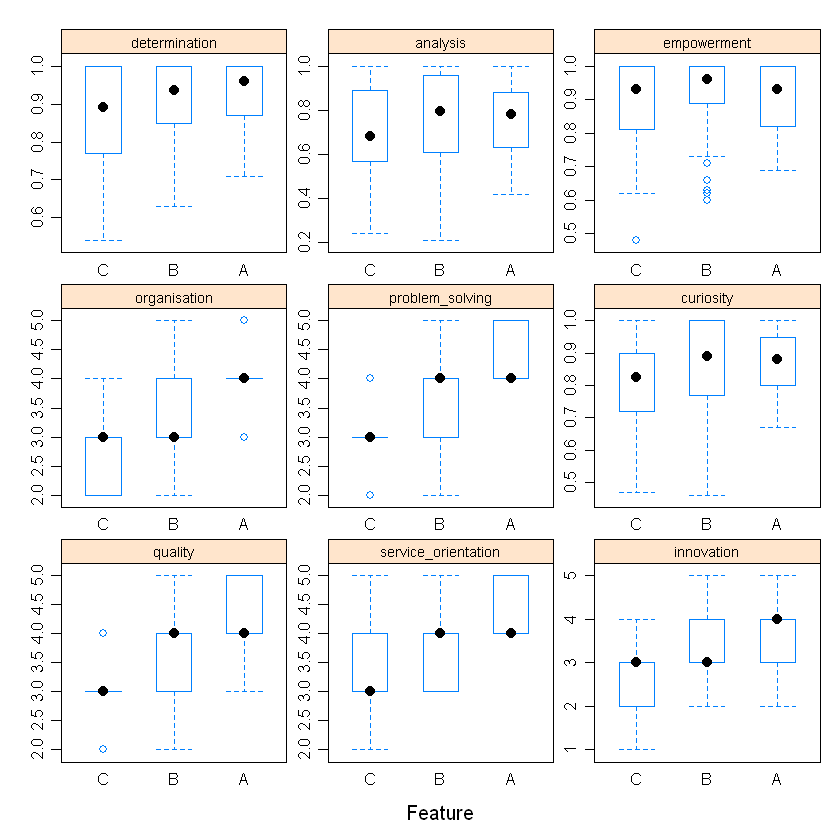

In [21]:
#Grouped boxplots
caret::featurePlot(x = perf[, -1], 
                   y = perf$performance, 
                   plot = "box",
                   strip = strip.custom(par.strip.text = list(cex = .7)),
                   scales = list(x = list(relation = "free"), 
                                 y = list(relation = "free")),
                   auto.key = list(columns = 3))

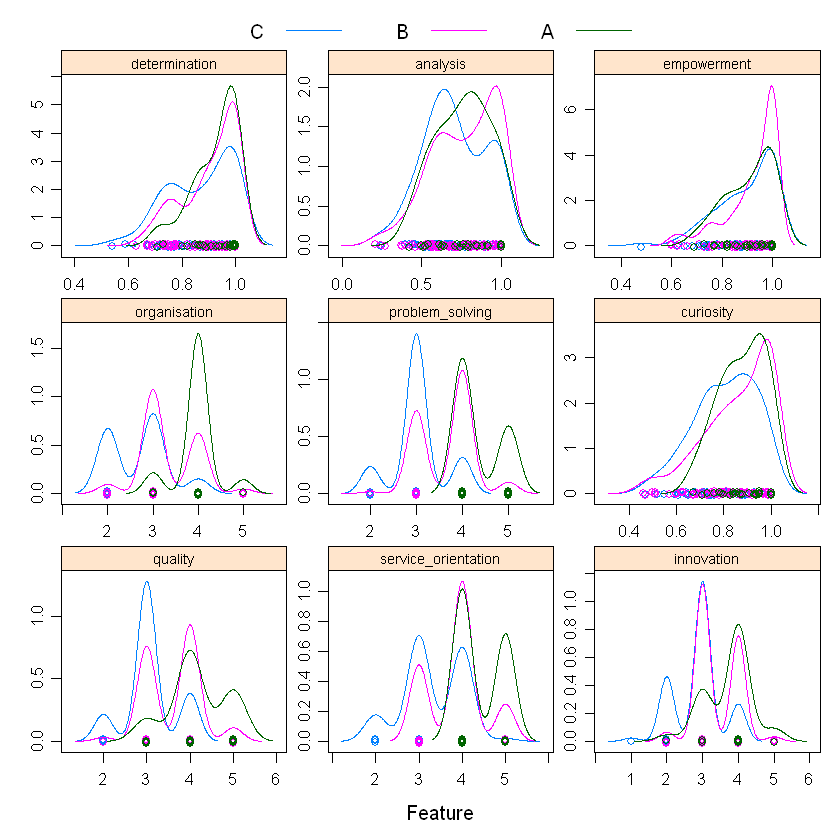

In [22]:
#Grouped density plots
caret::featurePlot(x = perf[, -1], 
                   y = perf$performance, 
                   plot = "density",
                   strip = strip.custom(par.strip.text = list(cex = .7)),
                   scales = list(x = list(relation = "free"), 
                                 y = list(relation = "free")),
                   auto.key = list(columns = 3))

## 4.7 Importance of variables as predictors (generic method)

The filterVarImp function from the caret framework provides an easy method to estimate the importance of each predictor in (non-)linear models. In multi-class classification, importance is based on maximum pair-wise AUC.

The output confirms our conclusions from the EDA so far.

In [23]:
#Linear filter
caret::filterVarImp(x = perf[, -1], 
                    y = perf$performance,
                    nonpara = F) %>% 
  rownames_to_column() %>% 
  arrange(desc(A))

rowname,C,B,A
<chr>,<dbl>,<dbl>,<dbl>
organisation,0.9047303,0.7567212,0.9047303
problem_solving,0.9027409,0.7594974,0.9027409
service_orientation,0.8695844,0.7210695,0.8695844
quality,0.8682582,0.7108416,0.8682582
innovation,0.8043767,0.6926336,0.8043767
curiosity,0.6618037,0.6373316,0.6618037
determination,0.6195844,0.5820296,0.6195844
analysis,0.5907757,0.5907757,0.5793546
empowerment,0.5611691,0.5651666,0.5651666


# 5. Save workspace
To use the workspace in a different notebook, I will save it as an R object to be able to import it into other notebooks.

In [24]:
save.image(file = "03_Objects/eda.RData")